<a href="https://colab.research.google.com/github/imjbmkz/boston_house_price_analysis/blob/main/SP102_PGA_Valdeleon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b>Predicting median house prices using Boston dataset</b>
Notebook submitted by: <b>Josh Valdeleon</b> <br>
Submitted on: 

In [ ]:
## NOTE: I used Google Colab for this work. Google Colab loads 
## matplotlib 3.2.2. My code has lines that aren't compatible with this
## version. Please run the line below to upgrade matplotlib if you're 
## version is below 3.5.1.

!pip install matplotlib --upgrade

In [ ]:
import sys, numpy, pandas, matplotlib, sklearn, statsmodels
print('Python v{}\n'.format(sys.version))
print('numpy v{}'.format(numpy.__version__))
print('pandas v{}'.format(pandas.__version__))
print('matplotlib v{}'.format(matplotlib.__version__))
print('statsmodels v{}'.format(statsmodels.__version__))
print('sklearn v{}'.format(sklearn.__version__))

Python v3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]

numpy v1.19.5
pandas v1.3.5
matplotlib v3.5.1
statsmodels v0.10.2
sklearn v1.0.2


### Introduction
This notebook contains the analysis that was conducted using the Boston dataset which contains the median prices along with the other details of the properties and location.

In [ ]:
## Import chdir function from os module
from os import chdir

## Make sure to mount Google Drive first if you're accessing files in Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

## Change working directory
chdir('/content/drive/MyDrive/Colab Notebooks/SP102')

In [ ]:
## Import packages

## Inline plotting
%matplotlib inline

## Packages for data manipulation and visualization
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

## Display diagrams for sklearn pipelines
from sklearn import set_config
set_config(display="diagram")

## sklearn classes for machine learning and column transformers
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

## Machine Learning models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

## Metrics for models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_validate, cross_val_predict

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## Load data
boston = pd.read_csv('Boston.csv', index_col=0)

### About the data
The data contains 506 samples and 14 columns. All columns are numeric, and there are no nulls. The following contains the description of each column. The background of the data can be read [here](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

| Column | Description                                                    |
| ------ | -------------------------------------------------------------- |
|crim    | per capita crime rate by town					                        |
|zn      | proportion of residential land zoned for lots over 25k sq.ft.  |
|indus   | proportion of non-retail business acres per town.         			|
|chas    | Charles River dummy variable (1 if tract bounds river	        |
|nox     | nitric oxides concentration (parts per 10 million)		          |
|rm      | average number of rooms per dwelling				                    |
|age     | proportion of owner-occupied units built prior to 1940		      |
|dis     | weighted distances to five Boston employment centres		        |
|rad     | index of accessibility to radial highways				              |
|tax     | full-value property-tax rate per 10,000 USD				            |
|ptratio | pupil-teacher ratio by town					                          |
|black   | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
|lstat   | % lower status of the population					                      |
|medv    | Median value of owner-occupied homes in 1k USD                 |

### Exploratory data analysis
Let's analyze the data by exploring each feature. We'll start by making a scatterplot of all features against the response variable `medv`.

#### Scatterplot on all variables

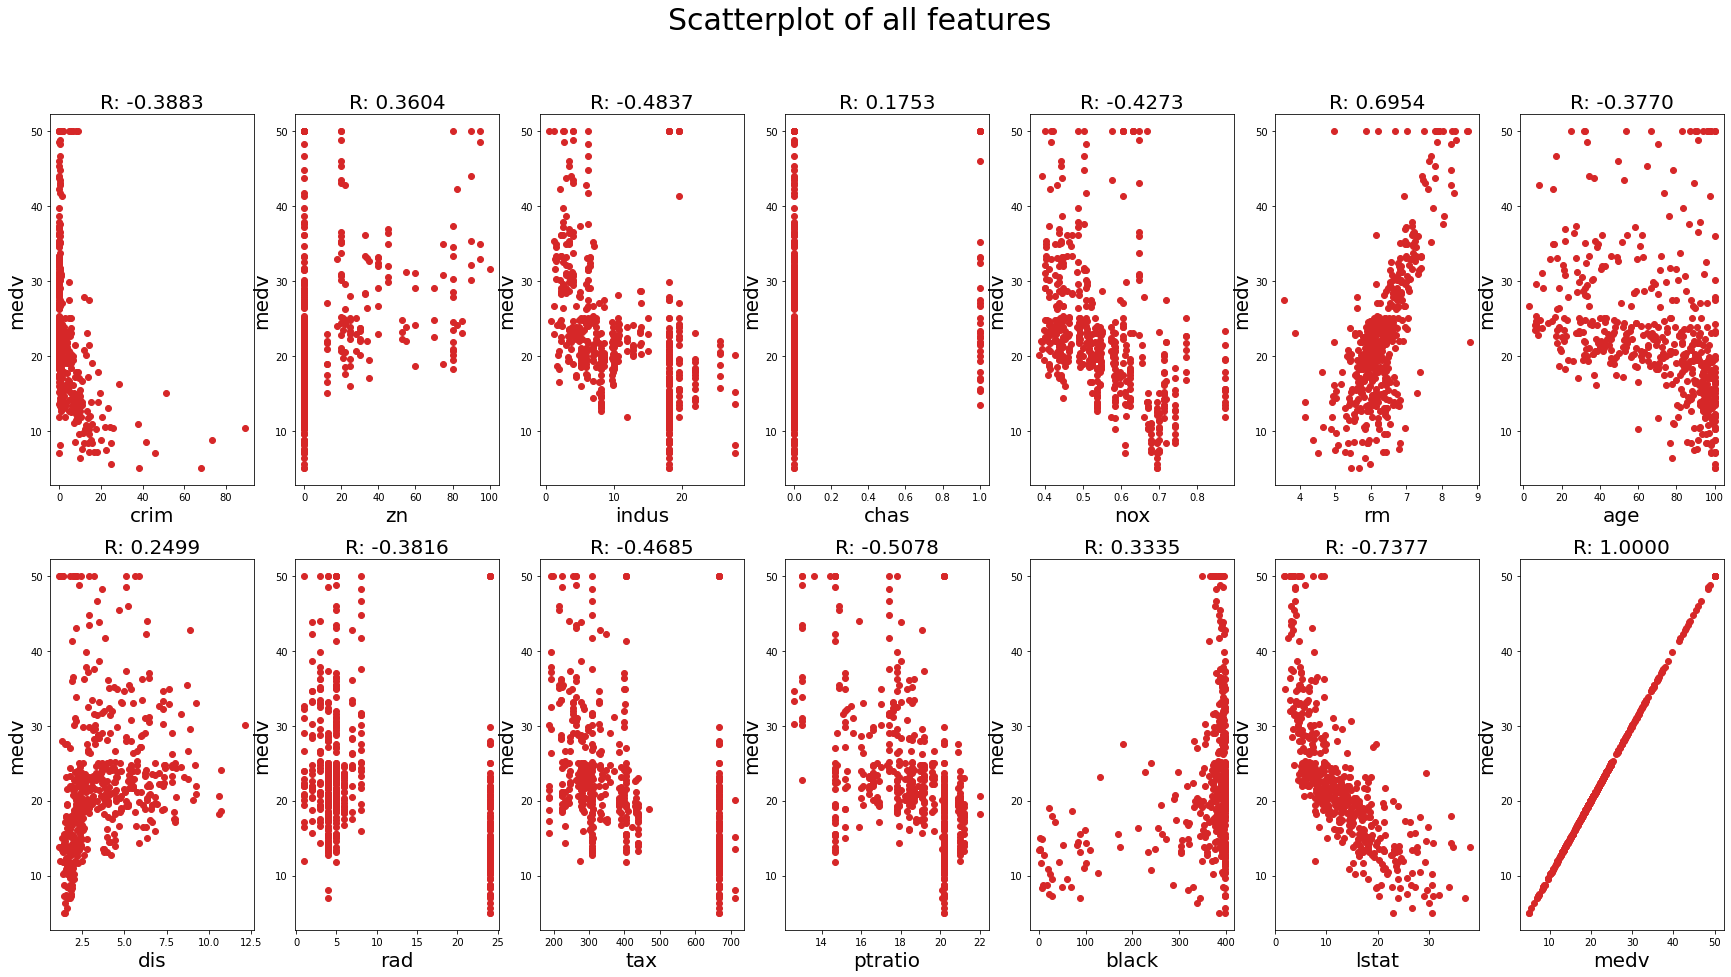

In [ ]:
## Column indexer
col_idx = 0

## Create plots with seven columns and two rows
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(30,15))

## Loop through each subplot to make scatterplot 
for i in range(2):
  for j in range(7):
    col = boston.iloc[:,col_idx].name
    axes[i, j].plot(boston[col], boston.medv, 'o', color='tab:red')
    axes[i, j].set_xlabel(boston.columns[col_idx], fontsize=20)
    axes[i, j].set_ylabel('medv', fontsize=20)
    axes[i, j].set_title('R: {:.4f}'.format(
        boston[['medv', col]].corr().iloc[0, 1]), fontsize=20)
    fig.suptitle('Scatterplot of all features', fontsize=30)
    col_idx += 1

## Save plot 
plt.savefig('scatter_all.png')

As we can see, many variables seem to have a weak correlation with the the response variable, and we can only pinpoint couple of variables that seem to have strong correlation (like `lstat`).

If we look at the data types stored in each column, we can see that `chas`, `rad,` and `tax` columns store discrete integer values. This means that these may be specific groups defined in the dataset. This is evident on the above scatterplot as these columns are making straight vertical lines.

In [ ]:
boston.dtypes

crim       float64
zn         float64
indus      float64
chas         int64
nox        float64
rm         float64
age        float64
dis        float64
rad          int64
tax          int64
ptratio    float64
black      float64
lstat      float64
medv       float64
dtype: object

#### Analyzing categorical variables
Let's count the number of unique values in each of these integer columns.

In [ ]:
## Loop through each column
for column in boston.columns:
  ## Check if column is int64
  if boston[column].dtype == 'int64':
    ## Print the number of unique values in an int64 column
    print('There are {} unique values in {} column.'.
          format(len(boston[column].unique()), column))

There are 2 unique values in chas column.
There are 9 unique values in rad column.
There are 66 unique values in tax column.


We can see that `tax` column had the most number of unique values, and we can't seem to work on that number of categories. As also explained from the data dictionary, this corresponds to full-value property-tax rate per 10,000 USD. We will consider this as a continuous variable. For `chas` and `rad`, we'll treat them as categorical variables.

Let's make a boxplot of these two variables.

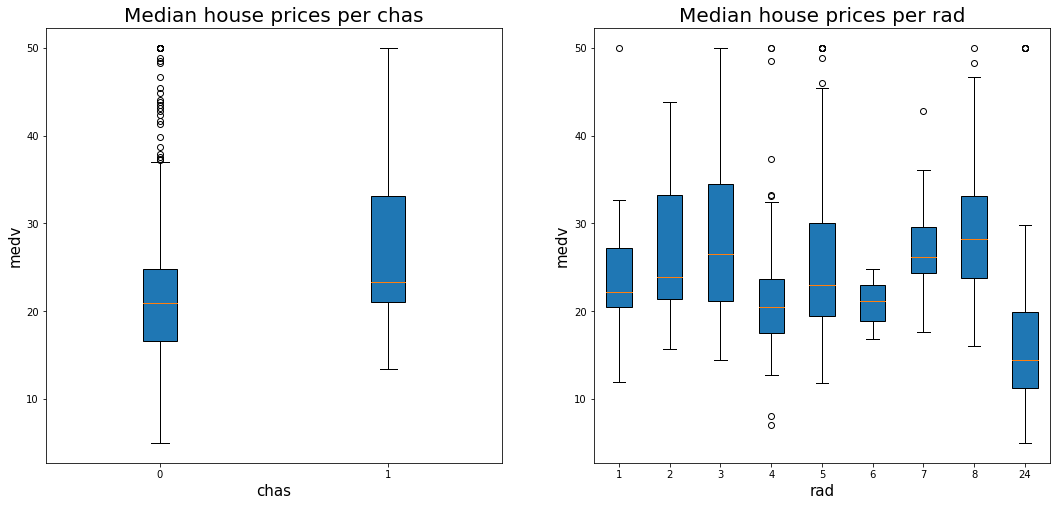

In [ ]:
## Convert tax to float
boston.tax = boston.tax.astype('float64')

## Define the list of categorical variables
cols = ['chas', 'rad']

## Get blank list of data to be plotted
data = []

## Loop through chas and rad columns 
for col in cols:
  ## Get blank dictionary for grouping
  groups = {}
  ## Get sorted unique values
  col_unique = sorted(boston[col].unique())
  ## Loop through each unique value to get filtered medv
  for unique in col_unique:
    groups[str(unique)] = boston.medv[boston[col]==unique].to_numpy()
  data.append(groups)

## Create plots with two columns and one row
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18,8))

## Loop through each subplot to make boxplots
for i in range(2):
  axes[i].boxplot(data[i].values(), labels=data[i].keys(), patch_artist=True)
  axes[i].set_xlabel(cols[i], fontsize=15)
  axes[i].set_ylabel('medv', fontsize=15)
  axes[i].set_title('Median house prices per {}'.format(cols[i]), fontsize=20)

plt.savefig('boxplot_chas_rad.png')

The above chart shows us the distribution of each category in `chas` and `rad` columns. Visually, we can see differences in the distribution of median house prices across each group. We can perform some statistical tests to see if these differences are significant or not.

In [ ]:
## Define the list of categorical variables
cols = ['chas', 'rad']

for col in cols:
  formula = 'medv ~ C({})'.format(col)
  model = ols(formula, boston).fit()
  print('{} variable:'.format(col))
  print('F Statistic: {:.4f}'.format(model.fvalue))
  print('p-value: {:.8f}'.format(model.f_pvalue))
  if model.f_pvalue < 0.05:
    print('The differences between groups are statistically significant.\n')
  else:
    print('The differences between groups are not statistically significant.\n')

chas variable:
F Statistic: 15.9715
p-value: 0.00007391
The differences between groups are statistically significant.

rad variable:
F Statistic: 18.4160
p-value: 0.00000000
The differences between groups are statistically significant.



The above results show us that the differences between these groups are statistically significant, which means that changes in these variables could significantly change the price of the property. For example, houses with `chas`=1 could be higher than those with `chas`=0 (not conclusive). 

#### Correlation 
Let's now look into the correlation of all variables to see if there are independent variables that are highly correlated.

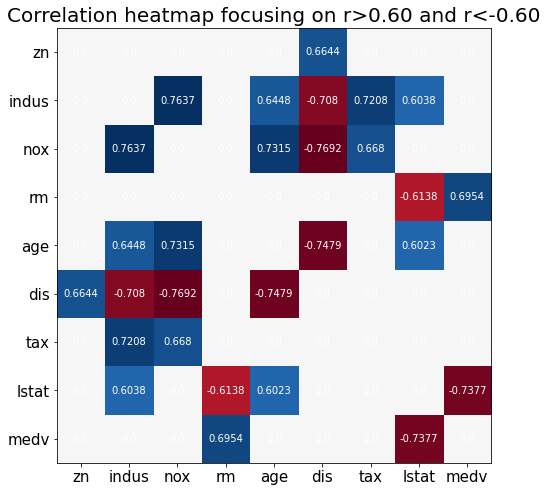

In [ ]:
## Set the correlation threshold
thresh = 0.6

## Remove chas and rad columns
boston_corr = boston.drop(['chas', 'rad'], axis=1)

## Get correlation matrix
correlation = boston_corr.corr()

## Filter correlation matrix to remove self-correlation 
## and select only those that exceeded the thresh
correlation = correlation[((correlation > thresh) | 
                           (correlation < -thresh)) & 
                          (correlation != 1)]

## Drop columns and rows that are completely na
correlation = correlation.dropna(how='all', axis=0)
correlation = correlation.dropna(how='all', axis=1)

## Get index and columns
index = correlation.index.to_list()
columns = correlation.columns.to_list()

## Fill remaining NAs with 0, and convert to numpy
correlation = correlation.fillna(0).to_numpy().round(4)

## Plot heatmap
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(correlation, cmap=plt.get_cmap('RdBu'))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(columns)), labels=columns, fontsize=15)
ax.set_yticks(np.arange(len(columns)), labels=columns, fontsize=15)

# Loop over data dimensions and create text annotations.
for i in range(len(index)):
    for j in range(len(columns)):
        text = ax.text(j, i, correlation[i, j], 
                       ha="center", va="center", color="w")

## Set title
ax.set_title('Correlation heatmap focusing on r>{:.2f} and r<{:.2f}'.
             format(thresh, -thresh), fontsize=20)

## Save plot
plt.savefig('heatmap_thresh.png')

This is the heatmap of correlation matrix of the entire dataframe. To summarize what transpired in the above code, I removed `chas` and `rad` columns since we've treated them as categorical data. We get the correlation of the remaining variables using `.corr()` method of pandas dataframe, and we removed the self-correlation and those that are less than the threshold we set. I did this to avoid cluttering our heatmap.

The remaining colored blocks show us which variables are highly correlated based on the threshold that we've set. Multicollinearity can be a problem in creating our machine learning models. We will process our data further to deal with highly correlated independent variables.

Lastly, `lstat` and `rm` columns are the only ones that are highly correlated with our response variable. `lstat` is inversely correlated, meaning, as we increase in the number of population with a lower status, the price of the property tends to go lower.

#### Feature Importance
Let's also look into the importance of each feature. We'll do this by creating a model first, then we can extract the importance of each defined by model. Then we will make a pareto chart to see which features are the most important based on the threshold we set.

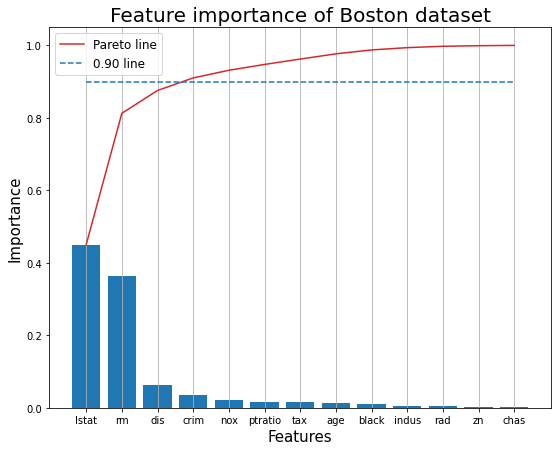

In [ ]:
## Define RandomForest
forest = RandomForestRegressor(random_state=42)

## Fit the training data
forest.fit(boston.drop('medv', axis=1), boston.medv)

## Get feature importance
feature_names_in_ = forest.feature_names_in_
feature_importances_ = forest.feature_importances_

## Make a dataframe out of the feature importance
importances_df = pd.DataFrame(
    {'features':feature_names_in_, 
     'importances':feature_importances_})
importances_df.sort_values(by='importances', ascending=False, inplace=True)

## Create a column that has the cummulative percentage
importances_df['cumperc'] = importances_df['importances'].cumsum() / importances_df['importances'].sum()

## Plot the feature importances
imp_rate = 0.9
fig, ax = plt.subplots(figsize=(9, 7))

## Plot the feature importances
ax.bar(importances_df['features'], importances_df['importances'])

## Plot the pareto chart
ax.plot(importances_df['features'], importances_df['cumperc'], 
        color='tab:red', label='Pareto line')

## Plot the threshold set
ax.hlines(imp_rate, importances_df['features'].iloc[0],
          importances_df['features'].iloc[-1], linestyle='--', 
          label='{:.2f} line'.format(imp_rate))
ax.grid(axis='x')
ax.set_xlabel('Features', fontsize=15)
ax.set_ylabel('Importance', fontsize=15)
ax.set_title('Feature importance of Boston dataset', fontsize=20)
ax.legend(prop=dict(size=12))

# ## Save plot
plt.savefig('feature_importance_pareto.png')

The above plot shows us the importance of each feature as defined by the Random Forest model that we've defined. These are represented by the blue bars. The pareto line shows us the cumulative rate of all these importances, and the blue dotted line represents the threshold we set to identify which columns cover the bulk of these importances. We can see that `crim` exceeded our threshold, hence, we can say that the most important features here are `lstat`, `rm`, `dis`, and `crim`.

### Predictive Analytics
We will now train some models. To get started, I will make a pipeline that will preprocess the data. Using the preprocessed data, we will train several models and choose the best parameters for them. Finally, we'll define a stacking regressor that will serve as an ensemble of the models we've used. 

Before we start defining what data preprocessing technique that I will use, I will drop the `black` column as it is tied with some [ethical issues](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8).

In [ ]:
## Drop black column
boston.drop('black', axis=1, inplace=True)

Also, I will now separate the features and labels of our data, then split them up into training and testing sets. 70% goes to training set, while we'll use the remaining 30% as testing data.

In [ ]:
## Separate features and label
X = boston.drop(['medv'], axis=1)
y = boston.medv.to_numpy()

## Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

#### Data preprocessing pipeline
After some exploratory analysis conducted, we've identified that some features of our data are skewed, some are highly correlated, and they don't have the same range of values. The pipeline that we aim to define will (1) identify the categorical variables in the data and use one hot encoding, (2) scale the continuous data so that the values will have a standard range, and (3) transform it to cancel the high correlation among variables. We will use `StandardScaler` which uses the formula $(x - \mu) / \sigma$. Then, we will use Principal Component Analysis to cancel out the high correlation among variables. To get the best number of principal components, we simply define a PCA with 12 components (number of features) and get the number of components with the highest explained variance ratio.

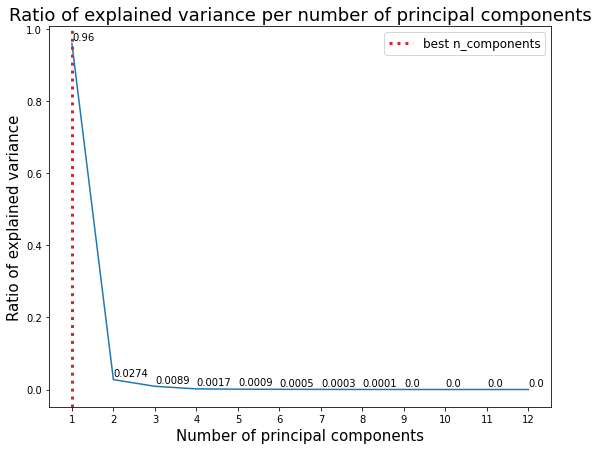

In [ ]:
## Define PCA with 12 principal components (number of columns)
n_cols = X.shape[1]
pca = PCA(n_cols).fit(X)

## Plot the ratio of explained variance per principal component
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(np.arange(1, n_cols + 1), pca.explained_variance_ratio_)
ax.axvline(np.argmax(pca.explained_variance_ratio_)+1, linestyle=":",
           label="best n_components", color='tab:red', linewidth=3)
ax.legend(prop=dict(size=12))
ax.set_title('Ratio of explained variance per number of principal components', 
             fontsize=18)
ax.set_xlabel('Number of principal components', fontsize=15)
ax.set_ylabel('Ratio of explained variance', fontsize=15)
ax.set_xticks(np.arange(1, n_cols + 1))
for i in range(n_cols):
  ax.text(i + 1, pca.explained_variance_ratio_[i] + 0.01, 
          pca.explained_variance_ratio_[i].round(4))

## Save plot
plt.savefig('pca.png')

As we can see from the above plot, having only one principal component explains ~96% of the variability in our data. We can use 3 principal components so that we can account for ~99% of the variability in our data.

We can now define our data preprocessing pipeline.

In [ ]:
## Define column selector
cat_selector = make_column_selector(dtype_include='int64')
num_selector = make_column_selector(dtype_include='float64')

## Define data transformers
onehot_enc = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()
pca = PCA(3)

## Define the column transformer
transformer = make_column_transformer(
    (onehot_enc, cat_selector), (scaler, num_selector)
)

## Define steps in preprocessing
steps = [('transformer', transformer), ('pca', pca)]

## Define pipeline
preprocessing_pipe = Pipeline(steps=steps)

preprocessing_pipe

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f382e9dddd0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f382e7c0890>)])),
                ('pca', PCA(n_components=3))])

We can then feed our input data into our pipeline, and transform it.

In [ ]:
## Fit the training data in our pipeline, and transform it
X_train_preprocessed = preprocessing_pipe.fit_transform(X_train)

## Transform the testing data (no need to fit)
X_test_preprocessed = preprocessing_pipe.transform(X_test)

#### Hyperparameter Tuning
Our input data is ready to be fed into the machine learning models. Let's now define the models to be used and the parameters needed to search for the best estimator of each model.

In [ ]:
## Define LinearRegression; LinearRegression does not have hyperparameters
linear_regression = LinearRegression()

## Define Lasso and parameters to be used for hyperparameter tuning
lasso = Lasso(random_state=42)
lasso_parameters = {
    'alpha':np.logspace(-4, -0.5, 30).round(4),
    'max_iter':[100, 1_000],
    'selection':['cyclic', 'random']
}

## Define Ridge and parameters to be used for hyperparameter tuning
ridge = Ridge(random_state=42)
ridge_parameters = {
    'alpha':np.logspace(-4, -0.5, 30).round(4),
    'max_iter':[100, 1_000],
    'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

## Define SVR and parameters to be used for hyperparameter tuning
svr = SVR()
svr_parameters = {
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale', 'auto'], 
    'C':[0.001, 0.1, 1.0, 10.0]
}

## Define DecisionTree and parameters to be used for hyperparameter tuning
tree = DecisionTreeRegressor(random_state=42)
tree_parameters = {
    'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter':['best', 'random'],
    'max_depth':[x for x in range(3, 16, 2)],
    'max_features':['auto', 'sqrt', 'log2']
}

## Define RandomForest and parameters to be used for hyperparameter tuning
forest = RandomForestRegressor(random_state=42)
forest_parameters = {
    'max_depth':[3, 5, 7, 9],
    'max_features':['auto', 'sqrt', 'log2']
}

## Define GradientBoosting and parameters to be used for hyperparameter tuning
xgb = GradientBoostingRegressor(random_state=42)
xgb_parameters = {
    'loss':['squared_error', 'absolute_error', 'huber'],
    'learning_rate':[0.0001, 0.001, 0.1],
    'criterion':['friedman_mse', 'squared_error'],
}


Let's now train these models using `GridSearchCV` to get their best parameters. 

In [ ]:
## Compress the models and parameters into lists
models = [linear_regression, lasso, ridge, svr, tree, forest, xgb]
params = [None, lasso_parameters, ridge_parameters, svr_parameters, 
          tree_parameters, forest_parameters, xgb_parameters]

## Create a blank list to store best estimators
best_models = []
scores = []

## Define repeated K-fold cross validation
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

## Loop to train each model and get best parameters
for i in range(len(models)):
  
  ## Skip LinearRegression
  if i==0:

    ## Fit data into the model
    %time linear_regression.fit(X_train_preprocessed, y_train)

    ## Append best_models list
    best_models.append(linear_regression)
    print('Done: LinearRegression')

    ## Predict new values
    y_hat = best_models[i].predict(X_train_preprocessed)

    ## Get scores (MAE and MSE)
    scores.append((mean_absolute_error(y_train, y_hat), 
                   mean_squared_error(y_train, y_hat)))
    print('MAE: {:.4f}'.format(scores[i][0]))
    print('MSE: {:.4f}\n'.format(scores[i][1]))
  
  ## Fit data to the models and get best estimators
  else:

    ## Fit data into the model
    grid_search_cv = GridSearchCV(models[i], param_grid=params[i], cv=rkf)
    %time grid_search_cv.fit(X_train_preprocessed, y_train)

    ## Append best_models list
    best_models.append(grid_search_cv.best_estimator_)
    print('Done: {}'.format(type(best_models[i]).__name__))

    ## Predict new values
    y_hat = best_models[i].predict(X_train_preprocessed)

    ## Get scores (MAE and MSE)
    scores.append((mean_absolute_error(y_train, y_hat), 
                   mean_squared_error(y_train, y_hat)))
    print('MAE: {:.4f}'.format(scores[i][0]))
    print('MSE: {:.4f}\n'.format(scores[i][1]))

print('Models have been tuned.')

CPU times: user 983 µs, sys: 0 ns, total: 983 µs
Wall time: 4.46 ms
Done: LinearRegression
MAE: 3.8592
MSE: 31.0184

CPU times: user 11.2 s, sys: 231 ms, total: 11.5 s
Wall time: 11.2 s
Done: Lasso
MAE: 3.8563
MSE: 31.0303

CPU times: user 31 s, sys: 174 ms, total: 31.1 s
Wall time: 30.9 s
Done: Ridge
MAE: 3.8591
MSE: 31.0184

CPU times: user 17.6 s, sys: 16.3 ms, total: 17.6 s
Wall time: 17.5 s
Done: SVR
MAE: 2.5617
MSE: 20.1714

CPU times: user 18 s, sys: 74.2 ms, total: 18 s
Wall time: 18 s
Done: DecisionTreeRegressor
MAE: 2.2175
MSE: 13.2343

CPU times: user 1min 23s, sys: 486 ms, total: 1min 23s
Wall time: 1min 23s
Done: RandomForestRegressor
MAE: 1.6333
MSE: 5.3886

CPU times: user 3min 17s, sys: 739 ms, total: 3min 18s
Wall time: 3min 17s
Done: GradientBoostingRegressor
MAE: 2.3830
MSE: 17.6948

Models have been tuned.


We're done training the models and we've tuned them to get the best parameters. To better illustrate how each performed, let's make a graph of the cross-validated MAE and MSE of each model.

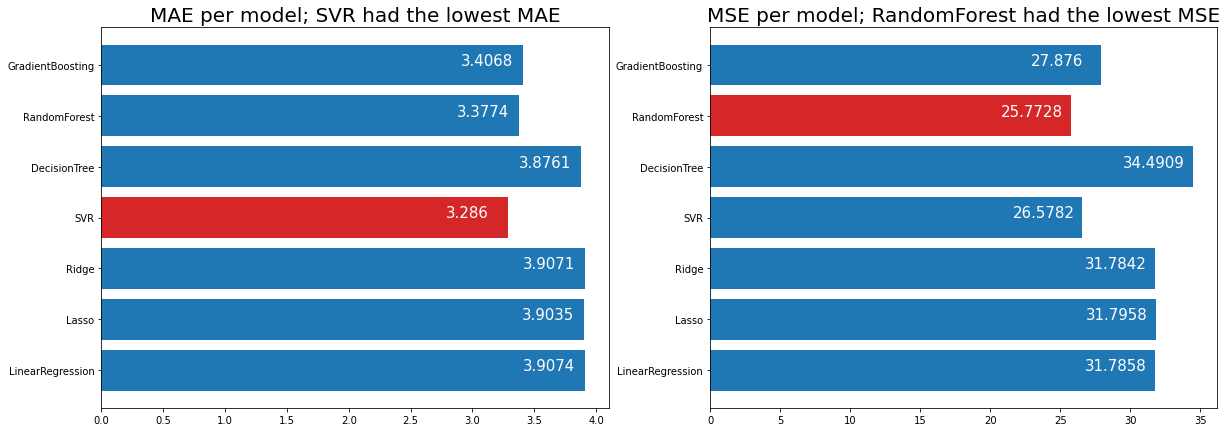

In [ ]:
## Get model names; remove 'Regressor'
model_names = [type(x).__name__ for x in best_models]
model_names = [x if x.find('Regressor') == -1 
               else x[0:x.find('Regressor')] 
               for x in model_names]

## Get cross-validate scores per model
model_scores = []; model_mae = []; model_mse = []
for i in range(len(best_models)):
  model_scores.append(
      cross_validate(
      best_models[i], X_train_preprocessed, y_train, cv=rkf, n_jobs=2, 
      scoring=['neg_mean_squared_error', 'neg_mean_absolute_error']))
  model_mae.append(-model_scores[i]['test_neg_mean_absolute_error'].mean())
  model_mse.append(-model_scores[i]['test_neg_mean_squared_error'].mean())

## Get index of minimum MAE and MSE
min_mae = np.argmin(model_mae)
min_mse = np.argmin(model_mse)

## Make bar plots 
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

## Make MAE bar plots
ax[0].barh(y=model_names, width=model_mae)

## Add text labels
for i in range(len(model_names)):
  ax[0].text(model_mae[i]-0.5, model_names[i], 
             round(model_mae[i], 4), color='w', fontsize=15)

## Highlight lowest MAE
ax[0].barh(y=model_names[min_mae], width=min(model_mae), color='tab:red')
ax[0].set_title('MAE per model; {} had the lowest MAE'.
                format(model_names[min_mae]), fontsize=20)

## Make MSE bar plots
ax[1].barh(y=model_names, width=model_mse)

## Add text labels
for i in range(len(model_names)):
  ax[1].text(model_mse[i]-5, model_names[i], 
             round(model_mse[i], 4), color='w', fontsize=15)

## Highlight lowest MSE
ax[1].barh(y=model_names[min_mse], width=min(model_mse), color='tab:red')
ax[1].set_title('MSE per model; {} had the lowest MSE'.
                format(model_names[min_mse]), fontsize=20)

## Save plot
plt.savefig('mae_mse.png')

The above plots are the cross validated MAE and MSE of all models. We use cross validation to better measure our models' accuracy for unseen data. 

MAE stands for mean absolute value. We can get this by subtracting the predicted value from the actual value, and get their absolute value. We do that for all samples, and get their mean ($MAE=1/n\sum{|Y-\hat{Y}|}$). Support vector regression model had the lowest MAE score of ~3.28, which means that our predictions using random forest may be off by +/-3.28. In real data, that's a gap of 3,280 USD since the values in `medv` column are in 1,000 USD.

MSE stands for mean squared error. We can get this by subtracting the predicted value from the actual value, and square the difference. We do that for all samples, and get their mean ($MSE=1/n\sum{(Y-\hat{Y})^2}$). Random forest model had the lowest MSE score of ~25.77. Note that these are squared differences, which is why the values are significantly higher than MAE's estimates. To better interpret this, we can get its root, which is about 5.07 or 5,070 USD.

We can use MSE since it [penalizes](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d) large errors in our predictions.

In [ ]:
## Store the best model in best_model variable
best_model = best_models[5]

#### Stacking Regressor
Now that we have tuned all models to get the best set of parameters, we can now make a stacking regressor. As defined from documentation of sklearn, stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Let's define our stacked regression model.

In [ ]:
## Create estimators list containing name of models and estimators
estimators = [(type(x).__name__, x) for x in best_models]

## Remove Random Forest (best model)
estimators.remove(estimators[5])

## Define stacking regressor
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=best_models[5], cv=10)

stacking_regressor

StackingRegressor(cv=10,
                  estimators=[('LinearRegression', LinearRegression()),
                              ('Lasso',
                               Lasso(alpha=0.0788, max_iter=100,
                                     random_state=42)),
                              ('Ridge',
                               Ridge(alpha=0.3162, max_iter=100,
                                     random_state=42, solver='saga')),
                              ('SVR', SVR(C=10.0, gamma='auto')),
                              ('DecisionTreeRegressor',
                               DecisionTreeRegressor(criterion='absolute_error',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     random_state=42)),
                              ('GradientBoostingRegressor',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         loss='absolute_error',
                                                         random_state=42))],
                  final_estimator=RandomForestRegressor(max_depth=9,
                                                        max_features='sqrt',
                                                        random_state=42))

We can then fit our data into the model.

In [ ]:
## Fit the training data
stacking_regressor.fit(X_train_preprocessed, y_train)

StackingRegressor(cv=10,
                  estimators=[('LinearRegression', LinearRegression()),
                              ('Lasso',
                               Lasso(alpha=0.0788, max_iter=100,
                                     random_state=42)),
                              ('Ridge',
                               Ridge(alpha=0.3162, max_iter=100,
                                     random_state=42, solver='saga')),
                              ('SVR', SVR(C=10.0, gamma='auto')),
                              ('DecisionTreeRegressor',
                               DecisionTreeRegressor(criterion='absolute_error',
                                                     max_depth=5,
                                                     max_features='auto',
                                                     random_state=42)),
                              ('GradientBoostingRegressor',
                               GradientBoostingRegressor(criterion='squared_error',
                                                         loss='absolute_error',
                                                         random_state=42))],
                  final_estimator=RandomForestRegressor(max_depth=9,
                                                        max_features='sqrt',
                                                        random_state=42))

To see how it performed, let's get its MAE, MSE, and RMSE with cross validation.

In [ ]:
# Get cross validated scores
score = cross_validate(
    stacking_regressor, X_train_preprocessed, y_train, cv=rkf, n_jobs=2, 
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

## Print results
print('MAE: {:.4f}'.format(-score['test_neg_mean_absolute_error'].mean()))
print('MSE: {:.4f}'.format(-score['test_neg_mean_squared_error'].mean()))
print('RMSE: {:.4f}'.format((-score['test_neg_mean_squared_error'].mean())**0.5))

MAE: 3.5161
MSE: 27.5840
RMSE: 5.2520


Support vector regression and random forest still outperformed the stacked regressor. The final test that we can make is to use both random forest and stacked regressor to see how they perform on our testing set.

#### Model performance on testing data
We will now test the best model that we have, which is random forest, and our stacked regressor on the testing data. We will also visualize the results and predicted values, and get their cross validation scores.

In [ ]:
## Define lists to be used for iteration
test_models = [best_model, stacking_regressor]
elapsed_times = []
y_hats = []
test_scores = []

## Iterate through the two models to get cross validation scores
for model in test_models:
  elapsed_time = time()
  test_scores.append(cross_validate(
      model, X_test_preprocessed, y_test, cv=rkf, n_jobs=2, 
      scoring=['neg_root_mean_squared_error', 'r2']))
  elapsed_times.append(time() - elapsed_time)
  y_hats.append(cross_val_predict(
      model, X_test_preprocessed, y_test, n_jobs=2))

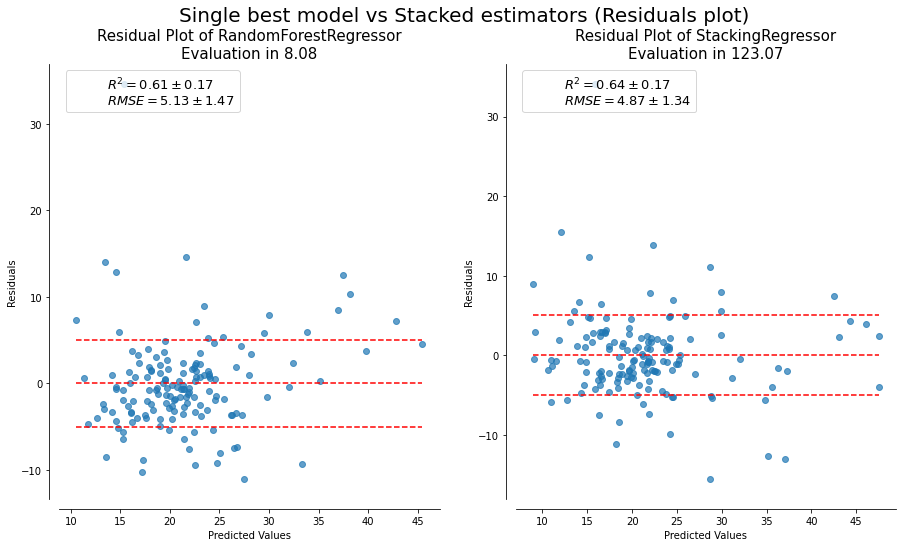

In [ ]:
## Make a residual plot 
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
for i in range(2):
  
  ## Make scatter plot of residuals and predicted values
  ax[i].scatter(y_hats[i], y_test-y_hats[i], alpha=0.7)

  ## Make some horizontal lines as guide
  ax[i].hlines(0, y_hats[i].min(), y_hats[i].max(), linestyle='--', color='red')
  ax[i].hlines(5, y_hats[i].min(), y_hats[i].max(), linestyle='--', color='red')
  ax[i].hlines(-5, y_hats[i].min(), y_hats[i].max(), linestyle='--', color='red')

  ## Some aesthetics
  ax[i].spines['top'].set_visible(False)
  ax[i].spines['right'].set_visible(False)
  ax[i].spines["left"].set_position(("outward", 10))
  ax[i].spines["bottom"].set_position(("outward", 10))

  ## Make legend
  extra = plt.Rectangle(
        (0, 0), 0, 0, fc="w", fill=False, edgecolor="none", linewidth=0
    )
  legend = (r"$R^2={:.2f} \pm {:.2f}$" + "\n" + r"$RMSE={:.2f} \pm {:.2f}$").format(
            np.mean(test_scores[i]["test_r2"]),
            np.std(test_scores[i]["test_r2"]),
            -np.mean(test_scores[i]["test_neg_root_mean_squared_error"]),
            np.std(test_scores[i]["test_neg_root_mean_squared_error"]),
        )
  ax[i].legend([extra], [legend], loc="upper left", fontsize=13)

  ## Labels and titles
  ax[i].set_xlabel('Predicted Values', fontsize=10)
  ax[i].set_ylabel('Residuals', fontsize=10)
  ax[i].set_title('Residual Plot of {}\nEvaluation in {:.2f}'.
                  format(type(test_models[i]).__name__,
                         elapsed_times[i]), fontsize=15)
  fig.suptitle('Single best model vs Stacked estimators (Residuals plot)', fontsize=20)

## Save plot
plt.savefig('test_results.png')

The above plot shows us the residual plots of both random forest and stacked regressor. Stacked regressor outperformed random forest in both RMSE and $R^2$. $R^2$ is the proportion of the variance of a dependent variable that is explained by the model ([C3.ai](https://c3.ai/glossary/data-science/coefficient-of-discrimination-r-squared-r2/)). Higher $R^2$ is better. We can also see that from a 5.25 RMSE, the performance of the stacked regressor improved by 0.48 points (4.87). The random forest, on the other hand, had some overfitting as we got a higher RMSE of 5.13 from 5.07 (difference of 0.06). $R^2$ score of 0.64 is not really that much. We would want it to be at least 0.7 and up.

To conclude, stacked regressor performed better than random forest on the testing set.

### Recommendations
We're done with our analysis. This part would just briefly discuss some recommendations as to how we can make better results during the next analysis.

1. Set a threshold for specific metric/s at the start of the analysis. This way, when you're still working with the training data, you could still go back to it, adjust model parameters, do other transformation techniques, etc. to enhance the performance of the model. Consider the standard errors of your metric for you to prepare for possible overfitting. 

2. The response variable can also be preprocessed. It is a little skewed. We can see from the previous plot that the prices are cluttering between 10 to 25. Transforming our response variable could lead to better estimation of our models. We can just convert it back to its raw form when interpreting it.

3. We can try to limit the features that will be fed into the models. -If we look back to the pareto chart of feature importance, there are only few variables that contribute the most in modeling the data to get predictions. We can reduce the features that will be fed into the model, and focus on the most important ones.

4. Further EDA can be made to better understand the relationship between different features (ie. clustering). By looking further into the structure of each feature, we can see further relationships that'll help in understanding how features affect the response variable.